# NOTEBOOK MULTICLASS ML (LESS SAMPLES): MACHINE LEARNING MULTICLASS CLASSIFICATION

## 1. OBJECTIVES

This notebook aims to perform multiclass classification (normal or a type of attack like XSS, SQL Injection...) using classical machine learning models trained with less samples. It will serve as a baseline to compare with LLM-based methods later in the project.

## 2. IMPORTS AND SETUP
Import the required python libraries, preprocessing, model training, and evaluation.

In [1]:
# numpy and pandas imports
import numpy as np
import pandas as pd
# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
# models imports
import torch
import torch.nn as nn
import torch.optim as optim
import xgboost as xgb
import lightgbm as lgb
import joblib as joblib
import os
# sklearn imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler

## 3. DATA LOADING
Load the EdgeIIoT dataset and filter it to retain the different class samples for the multiclass classification.

In [2]:
# Read dataset
csv_path = "../../data/dataset-csv/DNN-EdgeIIoT-dataset.csv"
df = pd.read_csv(csv_path,low_memory=False)
df.head()

,frame.time,ip.src_host,ip.dst_host,arp.dst.proto_ipv4,arp.opcode,arp.hw.size,arp.src.proto_ipv4,icmp.checksum,icmp.seq_le,icmp.transmit_timestamp,...,mqtt.proto_len,mqtt.protoname,mqtt.topic,mqtt.topic_len,mqtt.ver,mbtcp.len,mbtcp.trans_id,mbtcp.unit_id,Attack_label,Attack_type
0,2021 11:44:10.081753000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
1,2021 11:44:10.162218000,192.168.0.101,192.168.0.128,0,0.0,0.0,0,0.0,0.0,0.0,...,4.0,MQTT,0,0.0,4.0,0.0,0.0,0.0,0,Normal
2,2021 11:44:10.162271000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
3,2021 11:44:10.162641000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
4,2021 11:44:10.166132000,192.168.0.101,192.168.0.128,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,Temperature_and_Humidity,24.0,0.0,0.0,0.0,0.0,0,Normal


In [3]:
# print columns
print(df.columns)

Index(['frame.time', 'ip.src_host', 'ip.dst_host', 'arp.dst.proto_ipv4',
       'arp.opcode', 'arp.hw.size', 'arp.src.proto_ipv4', 'icmp.checksum',
       'icmp.seq_le', 'icmp.transmit_timestamp', 'icmp.unused',
       'http.file_data', 'http.content_length', 'http.request.uri.query',
       'http.request.method', 'http.referer', 'http.request.full_uri',
       'http.request.version', 'http.response', 'http.tls_port', 'tcp.ack',
       'tcp.ack_raw', 'tcp.checksum', 'tcp.connection.fin',
       'tcp.connection.rst', 'tcp.connection.syn', 'tcp.connection.synack',
       'tcp.dstport', 'tcp.flags', 'tcp.flags.ack', 'tcp.len', 'tcp.options',
       'tcp.payload', 'tcp.seq', 'tcp.srcport', 'udp.port', 'udp.stream',
       'udp.time_delta', 'dns.qry.name', 'dns.qry.name.len', 'dns.qry.qu',
       'dns.qry.type', 'dns.retransmission', 'dns.retransmit_request',
       'dns.retransmit_request_in', 'mqtt.conack.flags',
       'mqtt.conflag.cleansess', 'mqtt.conflags', 'mqtt.hdrflags', 'mqtt.len

In [4]:
# Save a backup of the dataframe
df_bp = df

## 4. FEATURE SELECTION AND PREPROCESSING
- Select the most important features based on prior analysis (e.g., feature importance from RandomForest).
- Encode categorical features if necessary.
- Normalize/scale the feature values.

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
# Check for missing values
df.isna().sum()

frame.time                   0
ip.src_host                  0
ip.dst_host                  0
arp.dst.proto_ipv4           0
arp.opcode                   0
arp.hw.size                  0
arp.src.proto_ipv4           0
icmp.checksum                0
icmp.seq_le                  0
icmp.transmit_timestamp      0
icmp.unused                  0
http.file_data               0
http.content_length          0
http.request.uri.query       0
http.request.method          0
http.referer                 0
http.request.full_uri        0
http.request.version         0
http.response                0
http.tls_port                0
tcp.ack                      0
tcp.ack_raw                  0
tcp.checksum                 0
tcp.connection.fin           0
tcp.connection.rst           0
tcp.connection.syn           0
tcp.connection.synack        0
tcp.dstport                  0
tcp.flags                    0
tcp.flags.ack                0
tcp.len                      0
tcp.options                  0
tcp.payl

### 4.1. FEATURE SELECTION

We use a random forest classifier to select the best 7 features.

dns.qry.name.len     0.205840
mqtt.protoname       0.138802
mqtt.msg             0.109687
mqtt.topic           0.101408
mqtt.conack.flags    0.095618
tcp.options          0.081726
tcp.dstport          0.055727
dtype: float64


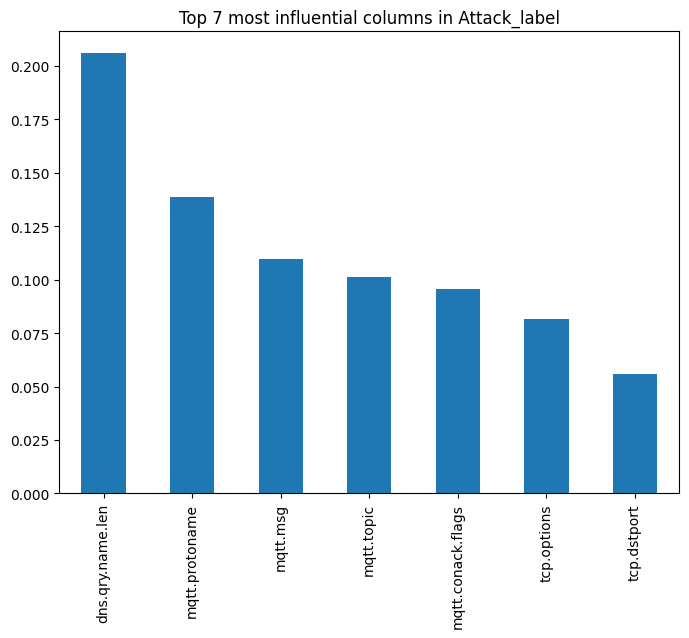

In [7]:
# Convert Attack_label to an integer (0 or 1)
df["Attack_label"] = df["Attack_label"].astype(int)

# Remove unnecessary columns
df = df.drop(["frame.time", "Attack_type"], axis=1, errors="ignore")

# Convert categorical variables into numerical values
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Separate features and target variable
X = df.drop(columns=["Attack_label"])
y = df["Attack_label"]

# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Display the top 15 most influential features
print(feature_importance.head(7))

# Plot feature importance
plt.figure(figsize=(8,6))
feature_importance.head(7).plot(kind="bar")
plt.title("Top 7 most influential columns in Attack_label")
plt.show()

In [8]:
# Define the selected columns
selected_columns = [
    "dns.qry.name.len", "mqtt.protoname", "mqtt.msg", "mqtt.topic", "mqtt.conack.flags",
    "tcp.options", "tcp.dstport"
]

# Filter the dataset to keep only these columns + target variable
df_selected = df_bp[selected_columns + ["Attack_type"]]

In [9]:
df_selected.head()

,dns.qry.name.len,mqtt.protoname,mqtt.msg,mqtt.topic,mqtt.conack.flags,tcp.options,tcp.dstport,Attack_type
0,0,0,0,0,0,020405b40101040201030307,64855.0,Normal
1,0,MQTT,0,0,0,0,1883.0,Normal
2,0,0,0,0,0,0,64855.0,Normal
3,0,0,0,0,0x00000000,0,64855.0,Normal
4,0,0,32342e36382037362e34320d0a,Temperature_and_Humidity,0,0,1883.0,Normal


In [10]:
# print the typws of Attack
print(df_selected["Attack_type"].unique()) 

['Normal' 'MITM' 'Uploading' 'Ransomware' 'SQL_injection' 'DDoS_HTTP'
 'DDoS_TCP' 'Password' 'Port_Scanning' 'Vulnerability_scanner' 'Backdoor'
 'XSS' 'Fingerprinting' 'DDoS_UDP' 'DDoS_ICMP']


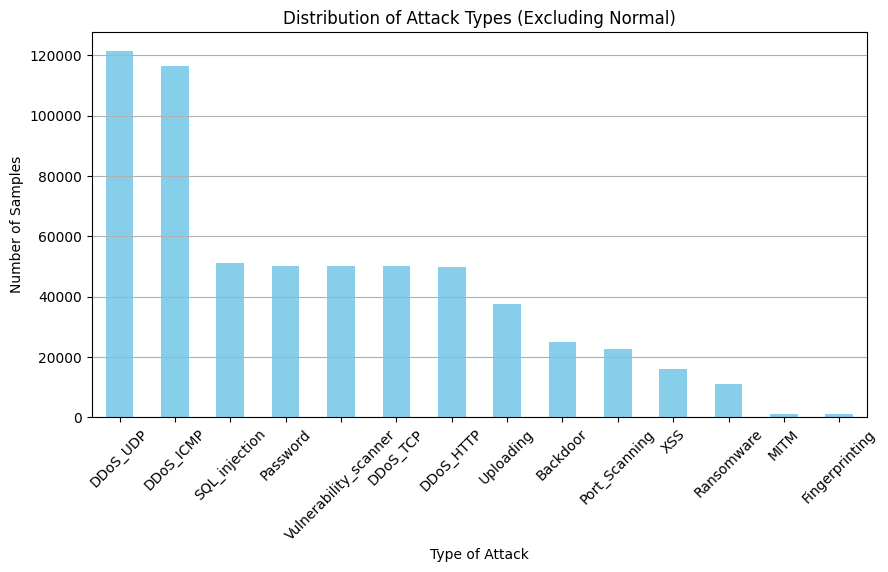

In [11]:
# Filter out the "Normal" category
df_filtered = df_selected[df_selected["Attack_type"] != "Normal"]

# Count occurrences of each attack type (excluding the normal samples)
attack_counts_filtered = df_filtered["Attack_type"].value_counts()

# Plot the attack distribution
plt.figure(figsize=(10, 5))
attack_counts_filtered.plot(kind="bar", color="skyblue")
plt.title("Distribution of Attack Types (Excluding Normal)")
plt.xlabel("Type of Attack")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.grid(axis="y")

# Show the plot
plt.show()

### 4.2. FEATURE PREPROCESSING

Get 1k samples for each type of attack and normal samples and apply one-hot encoding for the categorical columns. Also, use label encoder to transform the categorical labels to numerical labels.

In [12]:
# Split features and target variable
X = df_selected.drop(columns=["Attack_type"])
y = df_selected["Attack_type"]

In [13]:
# Define number of samples per class
samples_per_class = 500

# Check if "Attack_type" exists in df_selected
if "Attack_type" not in df_selected.columns:
    raise ValueError("Column 'Attack_type' not found in df_selected.")

# Select 500 samples for "Normal" traffic
normal_samples = df_selected[df_selected["Attack_type"] == "Normal"].sample(
    n=min(samples_per_class, len(df_selected[df_selected["Attack_type"] == "Normal"])),
    random_state=42
)

# Select 500 samples for each attack type
attack_samples = df_selected[df_selected["Attack_type"] != "Normal"].groupby("Attack_type").apply(
    lambda x: x.sample(n=min(samples_per_class, len(x)), random_state=42)
).reset_index(drop=True)

# Combine normal and attack samples into a balanced dataset (500 samples each)
df_balanced = pd.concat([normal_samples, attack_samples])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Split features and target variable
X = df_balanced.drop(columns=["Attack_type"])  # Features
y = df_balanced["Attack_type"]  # Target (multi-class)

# Display dataset info
print(df_balanced["Attack_type"].value_counts())

# Display first rows to check
df_balanced.head()

Attack_type
Backdoor                 500
Uploading                500
DDoS_ICMP                500
Vulnerability_scanner    500
Fingerprinting           500
XSS                      500
DDoS_HTTP                500
Ransomware               500
Password                 500
SQL_injection            500
Normal                   500
Port_Scanning            500
MITM                     500
DDoS_UDP                 500
DDoS_TCP                 500
Name: count, dtype: int64


/tmp/ipykernel_14515/4085130350.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  attack_samples = df_selected[df_selected["Attack_type"] != "Normal"].groupby("Attack_type").apply(


,dns.qry.name.len,mqtt.protoname,mqtt.msg,mqtt.topic,mqtt.conack.flags,tcp.options,tcp.dstport,Attack_type
0,0.0,0.0,0.0,0.0,0.0,0101080a3df2b58a2b88a4a5,60210.0,Backdoor
1,0.0,0.0,0.0,0.0,0.0,020405b40402080a408602750000000001030307,80.0,Uploading
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DDoS_ICMP
3,0.0,0.0,0.0,0.0,0.0,0101080a3fc0d6a6494202ac,80.0,Vulnerability_scanner
4,0.0,0.0,0.0,0.0,0.0,0101080a4a049ce140837286,58968.0,Uploading


In [14]:
# Columns to One-Hot Encode
categorical_columns = ["dns.qry.name.len","mqtt.protoname", "mqtt.msg", "mqtt.topic", "mqtt.conack.flags", "tcp.options"]

# Apply One-Hot Encoding
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

print(X.head())


   tcp.dstport  dns.qry.name.len_0.0  dns.qry.name.len_1.0  \
0      60210.0                  True                 False   
1         80.0                  True                 False   
2          0.0                  True                 False   
3         80.0                  True                 False   
4      58968.0                  True                 False   

   mqtt.protoname_0.0  mqtt.protoname_MQTT  mqtt.msg_0.0  \
0                True                False          True   
1                True                False          True   
2                True                False          True   
3                True                False          True   
4                True                False          True   

   mqtt.msg_32322e36382037322e38330d0a  mqtt.msg_32322e37362037322e39370d0a  \
0                                False                                False   
1                                False                                False   
2                            

In [15]:
print(X.columns)

Index(['tcp.dstport', 'dns.qry.name.len_0.0', 'dns.qry.name.len_1.0',
       'mqtt.protoname_0.0', 'mqtt.protoname_MQTT', 'mqtt.msg_0.0',
       'mqtt.msg_32322e36382037322e38330d0a',
       'mqtt.msg_32322e37362037322e39370d0a',
       'mqtt.msg_32332e30362037332e35300d0a',
       'mqtt.msg_32332e31392037332e37350d0a',
       ...
       'tcp.options_020405b40402080ae82096160000000001030307',
       'tcp.options_020405b40402080ae825f6c30000000001030307',
       'tcp.options_020405b40402080ae827808d0000000001030307',
       'tcp.options_020405b40402080ae82aa3040000000001030307',
       'tcp.options_020405b40402080ae82ed3e70000000001030307',
       'tcp.options_123.0', 'tcp.options_137.0', 'tcp.options_5353.0',
       'tcp.options_5355.0', 'tcp.options_67.0'],
      dtype='object', length=3763)


Transform categorical labels to numerical labels

In [16]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode attack types into integers
y = label_encoder.fit_transform(y)  # Convert labels into numeric format

# Print mapping of attack types to numbers
attack_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Attack Type Mapping:", attack_mapping)


Attack Type Mapping: {'Backdoor': np.int64(0), 'DDoS_HTTP': np.int64(1), 'DDoS_ICMP': np.int64(2), 'DDoS_TCP': np.int64(3), 'DDoS_UDP': np.int64(4), 'Fingerprinting': np.int64(5), 'MITM': np.int64(6), 'Normal': np.int64(7), 'Password': np.int64(8), 'Port_Scanning': np.int64(9), 'Ransomware': np.int64(10), 'SQL_injection': np.int64(11), 'Uploading': np.int64(12), 'Vulnerability_scanner': np.int64(13), 'XSS': np.int64(14)}


## 5. TRAIN AND TEST SPLIT
Split data in 70% train, 15% validation and 15% test.

In [17]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
)

## 6. MODELS TRAINING AND EVALUATION


### 6.1. RANDOM FOREST

In [18]:
# Define the parameter grid for RandomForest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20]
}

# base model
model = RandomForestClassifier(random_state=42)

# Search for the best hyperparameters using GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

# Train the model with GridSearchCV and the training data
grid_search.fit(X_train, y_train)

# Extract the best hyperparameters
model = grid_search.best_estimator_

# print the best hyperparameters
print("Best hyperparameters found:")
print(grid_search.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best hyperparameters found:
{'max_depth': None, 'n_estimators': 200}


In [19]:
# Train the model with the training set
model.fit(X_train, y_train)

# Evaluate model performance on the validation set
y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average="weighted", zero_division=0)
val_recall = recall_score(y_val, y_val_pred, average="weighted", zero_division=0)
val_f1 = f1_score(y_val, y_val_pred, average="weighted", zero_division=0)

print("Validation - Multi-Class Evaluation Results (RandomForest):")
print(f" - Accuracy: {val_accuracy:.4f}")
print(f" - Precision (Weighted): {val_precision:.4f}")
print(f" - Recall (Weighted): {val_recall:.4f}")
print(f" - F1-score (Weighted): {val_f1:.4f}")

# Evaluate model performance on the test set
y_pred_RF = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_RF)
test_precision = precision_score(y_test, y_pred_RF, average="weighted", zero_division=0)
test_recall = recall_score(y_test, y_pred_RF, average="weighted", zero_division=0)
test_f1 = f1_score(y_test, y_pred_RF, average="weighted", zero_division=0)

print("\nTest - Multi-Class Evaluation Results (RandomForest):")
print(f" - Accuracy: {test_accuracy:.4f}")
print(f" - Precision (Weighted): {test_precision:.4f}")
print(f" - Recall (Weighted): {test_recall:.4f}")
print(f" - F1-score (Weighted): {test_f1:.4f}")

Validation - Multi-Class Evaluation Results (RandomForest):
 - Accuracy: 0.4768
 - Precision (Weighted): 0.5564
 - Recall (Weighted): 0.4768
 - F1-score (Weighted): 0.4436

Test - Multi-Class Evaluation Results (RandomForest):
 - Accuracy: 0.4907
 - Precision (Weighted): 0.5913
 - Recall (Weighted): 0.4907
 - F1-score (Weighted): 0.4554


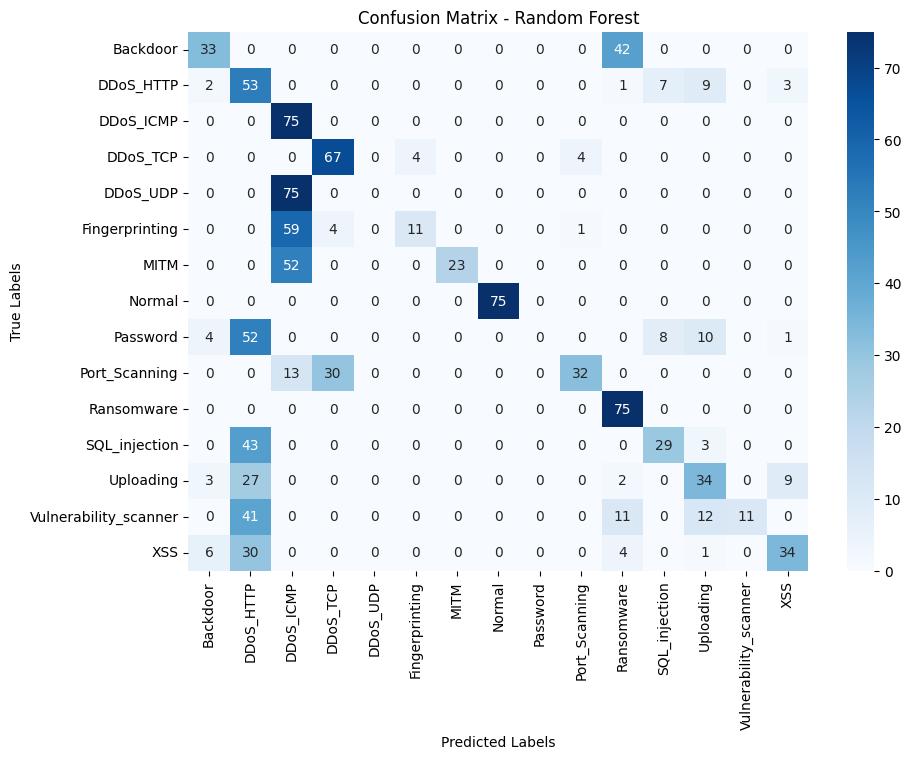

In [20]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_RF)

# Convert to DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [21]:
# export the model
joblib.dump(model, "../models/models_less_samples/random_forest_model.pkl")

['../models/models_less_samples/random_forest_model.pkl']

### 6.2. XGBOOST

In [22]:
# Train the model with the training set
model = xgb.XGBClassifier(
    n_estimators=100,  # Trees
    max_depth=6,       # Depth
    learning_rate=0.1,  # Learning rate
    subsample=0.8,      
    colsample_bytree=0.8, 
    random_state=42,
    eval_metric="mlogloss",
    early_stopping_rounds=10,
    verbosity=1
)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

[0]	validation_0-mlogloss:2.47361
[1]	validation_0-mlogloss:2.29049
[2]	validation_0-mlogloss:2.15805
[3]	validation_0-mlogloss:2.03999
[4]	validation_0-mlogloss:1.93744
[5]	validation_0-mlogloss:1.86361
[6]	validation_0-mlogloss:1.79085
[7]	validation_0-mlogloss:1.73095
[8]	validation_0-mlogloss:1.68083
[9]	validation_0-mlogloss:1.63053
[10]	validation_0-mlogloss:1.58425
[11]	validation_0-mlogloss:1.53859
[12]	validation_0-mlogloss:1.49990
[13]	validation_0-mlogloss:1.46632
[14]	validation_0-mlogloss:1.43573
[15]	validation_0-mlogloss:1.40555
[16]	validation_0-mlogloss:1.38164
[17]	validation_0-mlogloss:1.35965
[18]	validation_0-mlogloss:1.33685
[19]	validation_0-mlogloss:1.31742
[20]	validation_0-mlogloss:1.29815
[21]	validation_0-mlogloss:1.28014
[22]	validation_0-mlogloss:1.26118
[23]	validation_0-mlogloss:1.24443
[24]	validation_0-mlogloss:1.22950
[25]	validation_0-mlogloss:1.21593
[26]	validation_0-mlogloss:1.20268
[27]	validation_0-mlogloss:1.19222
[28]	validation_0-mlogloss:1.1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [23]:

# Evaluate model performance on the validation set
y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average="weighted", zero_division=0)
val_recall = recall_score(y_val, y_val_pred, average="weighted", zero_division=0)
val_f1 = f1_score(y_val, y_val_pred, average="weighted", zero_division=0)

print("Validation - Multi-Class Evaluation Results (XGBOOST):")
print(f" - Accuracy: {val_accuracy:.4f}")
print(f" - Precision (Weighted): {val_precision:.4f}")
print(f" - Recall (Weighted): {val_recall:.4f}")
print(f" - F1-score (Weighted): {val_f1:.4f}")

# Make Predictions on Test Data
y_pred_xg = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_xg)
test_precision = precision_score(y_test, y_pred_xg, average="weighted", zero_division=0)
test_recall = recall_score(y_test, y_pred_xg, average="weighted", zero_division=0)
test_f1 = f1_score(y_test, y_pred_xg, average="weighted", zero_division=0)

print("\nTest - Multi-Class Evaluation Results (XGBOOST):")
print(f" - Accuracy: {test_accuracy:.4f}")
print(f" - Precision (Weighted): {test_precision:.4f}")
print(f" - Recall (Weighted): {test_recall:.4f}")
print(f" - F1-score (Weighted): {test_f1:.4f}")

Validation - Multi-Class Evaluation Results (XGBOOST):
 - Accuracy: 0.5455
 - Precision (Weighted): 0.6699
 - Recall (Weighted): 0.5455
 - F1-score (Weighted): 0.5309

Test - Multi-Class Evaluation Results (XGBOOST):
 - Accuracy: 0.5164
 - Precision (Weighted): 0.6325
 - Recall (Weighted): 0.5164
 - F1-score (Weighted): 0.4987


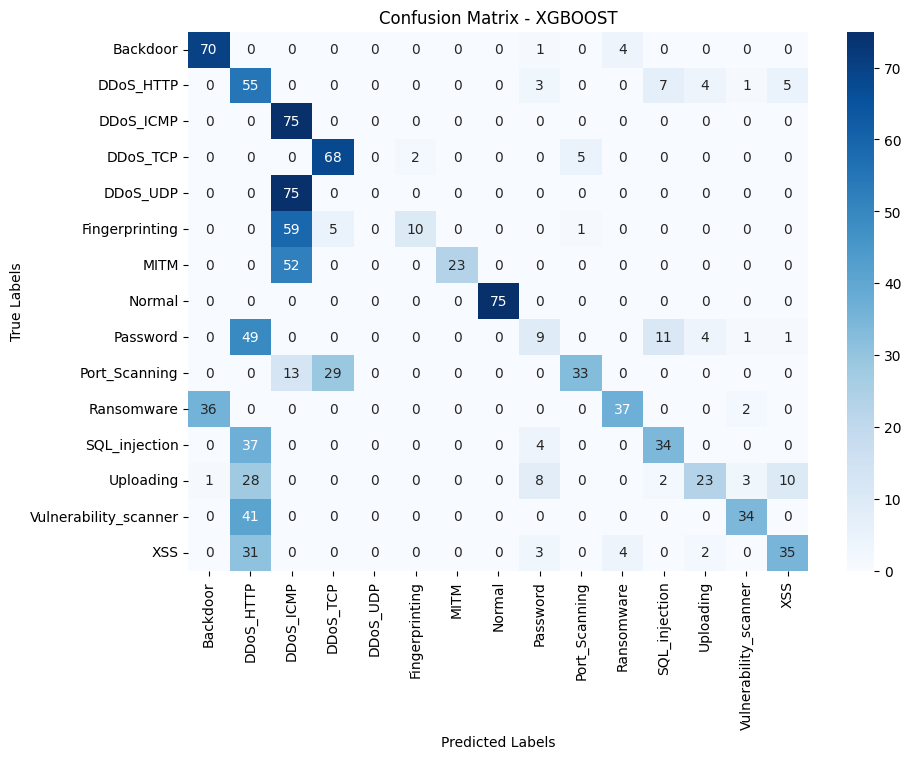

In [24]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_xg)

# Convert to DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - XGBOOST")
plt.show()

In [25]:
# export the model
joblib.dump(model, "../models/models_less_samples/xgboost_model.pkl")

['../models/models_less_samples/xgboost_model.pkl']

### 6.3. LIGHTGBM

In [26]:
# Train the model with the training set
model = lgb.LGBMClassifier(
    n_estimators=300,  
    max_depth=-1,  
    learning_rate=0.05,  
    num_leaves=50, 
    min_child_samples=10,  
    subsample=0.7,  
    colsample_bytree=0.7,  
    class_weight="balanced",  
    random_state=42,
    early_stopping_rounds=10,
    verbose=1
)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 5253, number of used features: 15
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [I

LGBMClassifier(class_weight='balanced', colsample_bytree=0.7,
               early_stopping_rounds=10, learning_rate=0.05,
               min_child_samples=10, n_estimators=300, num_leaves=50,
               random_state=42, subsample=0.7, verbose=1)

In [27]:
# Evaluate model performance on the validation set
y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average="weighted", zero_division=0)
val_recall = recall_score(y_val, y_val_pred, average="weighted", zero_division=0)
val_f1 = f1_score(y_val, y_val_pred, average="weighted", zero_division=0)

print("Validation - Multi-Class Evaluation Results (LIGHTGBM):")
print(f" - Accuracy: {val_accuracy:.4f}")
print(f" - Precision (Weighted): {val_precision:.4f}")
print(f" - Recall (Weighted): {val_recall:.4f}")
print(f" - F1-score (Weighted): {val_f1:.4f}")

# Make Predictions on Test Data
y_pred_lgbm = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_lgbm)
test_precision = precision_score(y_test, y_pred_lgbm, average="weighted", zero_division=0)
test_recall = recall_score(y_test, y_pred_lgbm, average="weighted", zero_division=0)
test_f1 = f1_score(y_test, y_pred_lgbm, average="weighted", zero_division=0)

print("\nTest - Multi-Class Evaluation Results (LIGHTGBM):")
print(f" - Accuracy: {test_accuracy:.4f}")
print(f" - Precision (Weighted): {test_precision:.4f}")
print(f" - Recall (Weighted): {test_recall:.4f}")
print(f" - F1-score (Weighted): {test_f1:.4f}")

Validation - Multi-Class Evaluation Results (LIGHTGBM):
 - Accuracy: 0.5410
 - Precision (Weighted): 0.6616
 - Recall (Weighted): 0.5410
 - F1-score (Weighted): 0.5252

Test - Multi-Class Evaluation Results (LIGHTGBM):
 - Accuracy: 0.5147
 - Precision (Weighted): 0.6335
 - Recall (Weighted): 0.5147
 - F1-score (Weighted): 0.4942


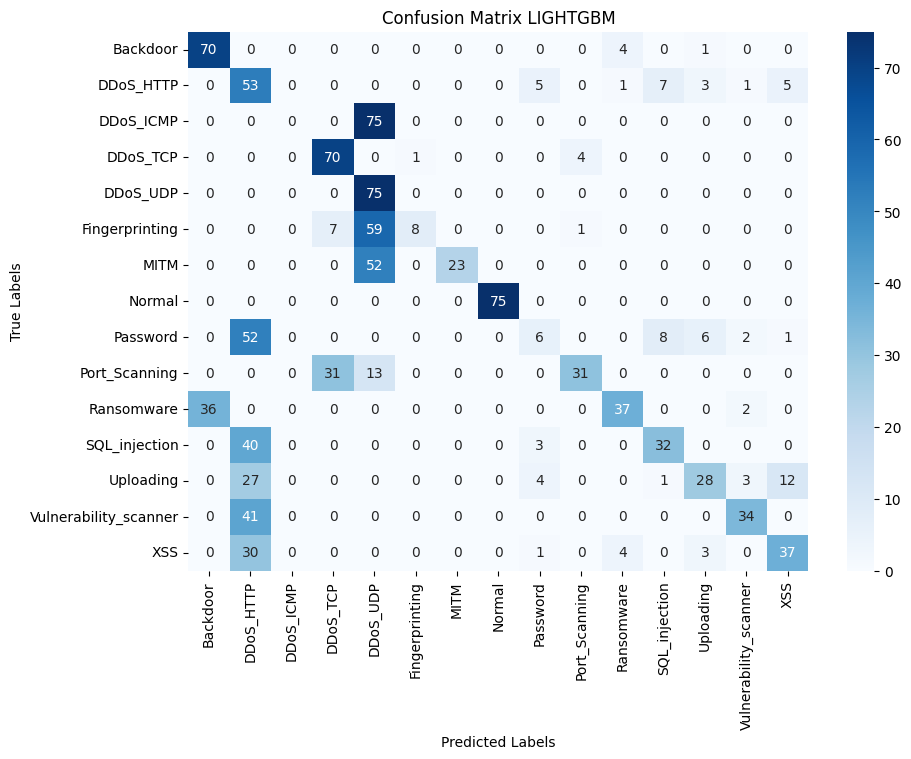

In [28]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_lgbm)

# Convert to DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix LIGHTGBM")
plt.show()

In [29]:
# export the model
joblib.dump(model, "../models/models_less_samples/lgbm_model.pkl")

['../models/models_less_samples/lgbm_model.pkl']

### 6.4. MLP

In [30]:
# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [31]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.3)

        self.layer2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)

        self.layer3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.3)

        self.output_layer = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.layer2(x)))
        x = self.dropout2(x)
        x = torch.relu(self.bn3(self.layer3(x)))
        x = self.dropout3(x)
        return self.output_layer(x)

In [32]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Initialize the model, loss function, optimizer and train
input_dim = X_train.shape[1]
output_dim = len(np.unique(y_train))
model = MLP(input_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [33]:
# Train the model
epochs = 100
batch_size = 64
for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Mini-batch training
    for i in range(0, X_train_tensor.shape[0], batch_size):
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 10/100, Loss: 0.9012
Epoch 20/100, Loss: 0.7101
Epoch 30/100, Loss: 1.6890
Epoch 40/100, Loss: 0.5647
Epoch 50/100, Loss: 0.7236
Epoch 60/100, Loss: 1.0542
Epoch 70/100, Loss: 0.6455
Epoch 80/100, Loss: 0.5862
Epoch 90/100, Loss: 0.8673
Epoch 100/100, Loss: 0.5798


In [34]:
# Evaluate model performance on the validation set
model.eval()
with torch.no_grad():
    y_val_pred = model(X_val_tensor).argmax(dim=1).numpy()

val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average="weighted", zero_division=0)
val_recall = recall_score(y_val, y_val_pred, average="weighted", zero_division=0)
val_f1 = f1_score(y_val, y_val_pred, average="weighted", zero_division=0)

print("Validation - Multi-Class evaluation results (MLP):")
print(f" - Accuracy: {val_accuracy:.4f}")
print(f" - Precision: {val_precision:.4f}")
print(f" - Recall: {val_recall:.4f}")
print(f" - F1-score: {val_f1:.4f}")

# Evaluate model performance on the test set
with torch.no_grad():
    y_pred_mlp = model(X_test_tensor).argmax(dim=1).numpy()

test_accuracy = accuracy_score(y_test, y_pred_mlp)
test_precision = precision_score(y_test, y_pred_mlp, average="weighted", zero_division=0)
test_recall = recall_score(y_test, y_pred_mlp, average="weighted", zero_division=0)
test_f1 = f1_score(y_test, y_pred_mlp, average="weighted", zero_division=0)

print("\nTest - Multi-Class evaluation results (MLP):")
print(f" - Accuracy: {test_accuracy:.4f}")
print(f" - Precision: {test_precision:.4f}")
print(f" - Recall: {test_recall:.4f}")
print(f" - F1-score: {test_f1:.4f}")


Validation - Multi-Class evaluation results (MLP):
 - Accuracy: 0.2299
 - Precision: 0.2614
 - Recall: 0.2299
 - F1-score: 0.1729

Test - Multi-Class evaluation results (MLP):
 - Accuracy: 0.2373
 - Precision: 0.2658
 - Recall: 0.2373
 - F1-score: 0.1774


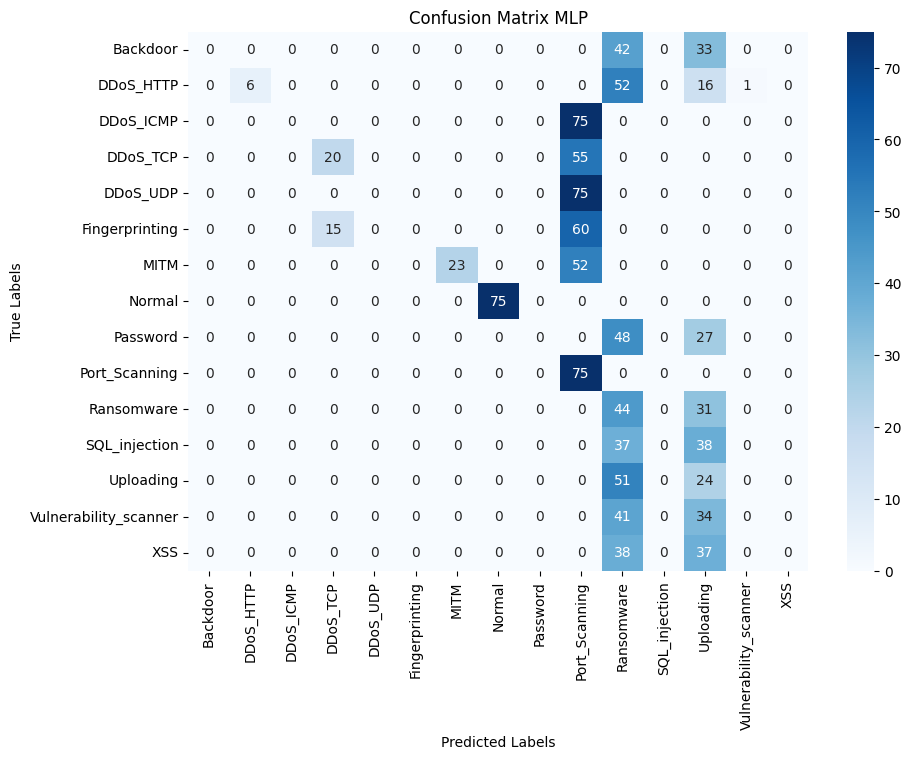

In [35]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_mlp)

# Convert to DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix MLP")
plt.show()

In [36]:
# export the model
joblib.dump(model, "../models/models_less_samples/mlp_model.pkl")

['../models/models_less_samples/mlp_model.pkl']

## 7. RESULTS COMPARISON

In [37]:
# Function to compute metrics
def compute_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred, average="weighted", zero_division=0),
        "Precision": precision_score(y_true, y_pred, average="weighted", zero_division=0),
        "Recall": recall_score(y_true, y_pred, average="weighted", zero_division=0),
    }

# Calculate metrics
metrics_mlp = compute_metrics(y_test, y_pred_mlp)
metrics_xgb = compute_metrics(y_test, y_pred_xg)
metrics_lgbm = compute_metrics(y_test, y_pred_lgbm)
metrics_rf = compute_metrics(y_test, y_pred_RF)

# Create dataframe
metrics_comparison_df = pd.DataFrame({
    "MLP": metrics_mlp,
    "XGBoost": metrics_xgb,
    "LightGBM": metrics_lgbm,
    "RandomForest": metrics_rf,
}).T  

# Show table
print(metrics_comparison_df)

              Accuracy  F1 Score  Precision    Recall
MLP           0.237333  0.177357   0.265827  0.237333
XGBoost       0.516444  0.498664   0.632539  0.516444
LightGBM      0.514667  0.494187   0.633489  0.514667
RandomForest  0.490667  0.455355   0.591269  0.490667


In [38]:
# Create folder if it doesn't exist
os.makedirs("../models/models_less_samples/exports", exist_ok=True)

# 1. Save the LabelEncoder
joblib.dump(label_encoder, "../models/models_less_samples/exports/label_encoder.pkl")

# 2. Save the feature names after One-Hot Encoding
joblib.dump(X.columns.tolist(), "../models/models_less_samples/exports/xgb_input_columns.pkl")

# 3. Save mapping of attack types to integers
joblib.dump(attack_mapping, "../models/models_less_samples/exports/attack_mapping.pkl")

# Save x and y after preprocessing
joblib.dump(X, "../models/models_less_samples/exports/X_encoded.pkl")
joblib.dump(y, "../models/models_less_samples/exports/y_encoded.pkl")

print("Preprocessing objects exported to '../models/models_less_samples/exports/'")

Preprocessing objects exported to '../models/models_less_samples/exports/'
